In [ ]:
from dataclasses import dataclass
from remadr import SerialPort, RemadrDevice, PulseTrainItem
import time
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from dataclasses import dataclass
from typing import List, Tuple
from serial import SerialTimeoutException

@dataclass
class Shot:
  voltageA: float
  voltageB: float
  shapeA: list[PulseTrainItem]
  shapeB: list[PulseTrainItem]
  velocity: float
  dwellA: float
  dwellB: float


def plot_points_with_error(points: List[Tuple[float, float]], epsilon: float = 10e-6, title: str = "", ylabel: str = ""):
    """
    Groups points with similar x-values (within epsilon), computes mean and std for y-values,
    and plots them with error bars.
    """
    # Group y-values by rounded x-values
    groups = defaultdict(list)
    for x, y in points:
        # Round x to nearest bucket (determined by epsilon)
        bucket = round(x / epsilon) * epsilon
        groups[bucket].append(y)

    xs = []
    ys = []
    yerrs = []

    for x, y_list in sorted(groups.items()):
        xs.append(x)
        ys.append(np.mean(y_list))
        yerrs.append(np.std(y_list) if len(y_list) > 1 else 0)

    plt.errorbar(xs, ys, yerr=yerrs, fmt='o', capsize=5)
    plt.xlabel("pulse_width")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()


def plot_multiple_with_error(
    datasets: List[Tuple[str, List[Tuple[float, float]]]],
    epsilon: float = 1e-5,
    title: str = "",
    ylabel: str = ""
):
    """
    Plots multiple sets of (x, y) points with error bars in a single figure.
    
    Parameters:
    - datasets: List of (label, list of (x, y) points)
    - epsilon: Threshold for grouping x-values
    - title: Plot title
    - ylabel: Y-axis label
    """
    plt.figure(figsize=(12, 8))
    
    for label, points in datasets:
        groups = defaultdict(list)
        for x, y in points:
            bucket = round(x / epsilon) * epsilon
            groups[bucket].append(y)

        xs = []
        ys = []
        yerrs = []

        for x, y_list in sorted(groups.items()):
            xs.append(x)
            ys.append(np.mean(y_list))
            yerrs.append(np.std(y_list) if len(y_list) > 1 else 0)

        plt.errorbar(xs, ys, yerr=yerrs, fmt='o', capsize=5, label=label)

    plt.xlabel("pulse_width")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()


devices = SerialPort.enumerate()
if not len(devices) == 1:
  raise "Stand RP2040 device must be connected"

try:
  if stand:
    stand.close()
except:
  pass

stand = RemadrDevice(devices[0][0])

state = stand.state
print("State: ", state)

# Set global default figure size (in inches)
plt.rcParams["figure.figsize"] = (12, 8)

State:  StateResult(stages=2, voltageA=1.636137, voltageB=1.3416, senseA=False, senseB=True, chronoA=True, chronoB=True)


In [ ]:
def make_single_stage_test(stand: RemadrDevice, shots: list[Shot], numtries=5):
  # Enable interactive plotting
  plt.ion()
  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111, projection='3d')
  xs, ys, zs = [], [], []
  surface = None

  def update_plot():
    nonlocal surface
    ax.clear()
    ax.set_title("Velocity vs Pulse Widths")
    ax.set_xlabel("Pulse Width N-2")
    ax.set_ylabel("Pulse Width N-1")
    ax.set_zlabel("Velocity (m/s)")
    
    # Draw surface if there's enough points
    if len(xs) >= 3:
      # Triangulate to form surface
      surface = ax.plot_trisurf(xs, ys, zs, cmap='viridis', edgecolor='none', alpha=0.8)
    else:
      ax.scatter(xs, ys, zs, color='r')

    plt.draw()
    plt.pause(0.1)

  def single_stage_test(args: list[float]) -> float:
    state = stand.state
    shape = [
      PulseTrainItem(delay, width)
      for delay, width in zip(args[::2], args[1::2])
    ]
    print("Testing: ", state, [i*1e6 for i in args], end='')
    stand.set_stage(0, shape)

    avg = 0
    cnt = 0
    for i in range(numtries):
      try:
        result = stand.drive()
      except TimeoutError:
        continue
      if result.drive and result.shot:
        time.sleep(2)
      shot = Shot(voltageA=state.voltageA, voltageB=state.voltageB, shapeA=shape, shapeB=None, velocity=0, dwellA=0, dwellB=0)
      if result.drive:
        shot.dwellA = result.drive.dA
        shot.dwellB = result.drive.dB
      if result.shot:
        shot.velocity = result.shot.speed
        avg+=shot.velocity
        cnt+=1

      shots.append(shot)
    if cnt:
      velocity = avg / cnt
      print(f" velocity={velocity:.4f} m/s")

      # Use the last two widths from shape for plotting
      if len(shape) >= 2:
        x = shape[-1].delay * 1e6
        y = shape[-1].pulse_width * 1e6
        xs.append(x)
        ys.append(y)
        zs.append(velocity)
        update_plot()

      return velocity
    else:
      print("  skip")  
      return 0
  return single_stage_test

In [3]:
# communication test
print(stand.state)
print(stand.set_stage(0, [PulseTrainItem(delay=1e-6, pulse_width=400e-6)]))
try:
  print(stand.drive())
except TimeoutError as e:
  print(e)

StateResult(stages=2, voltageA=18.716356, voltageB=18.854088, senseA=False, senseB=True, chronoA=True, chronoB=True)
[PulseTrainItem(delay=1e-06, pulse_width=0.00039999999999999996)]
No response received after drive command.


In [41]:
# stand.send("?")
while stand.receive() != '': pass


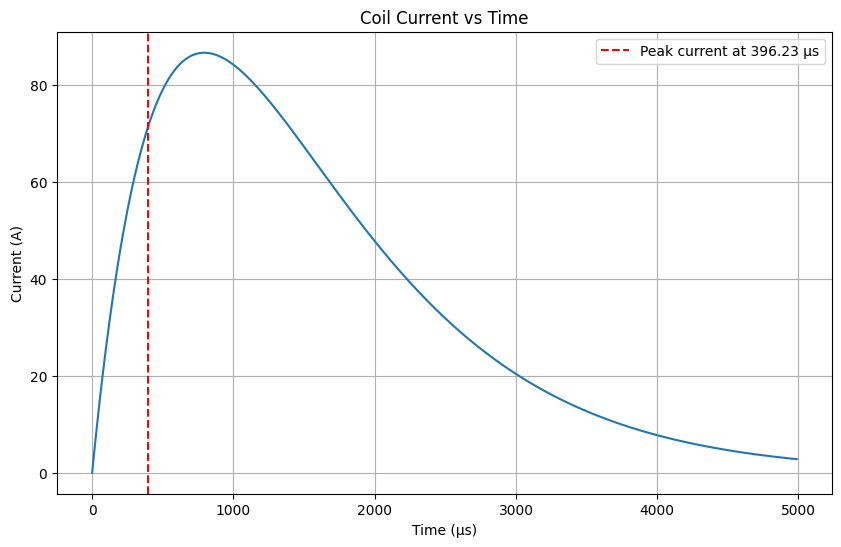

In [60]:
# Capacitor parameters
capacitor_value = 10000e-6  # Farads (200 μF)
capacitor_voltage = 18.7  # Volts
capacitor_esr = 15e-3  # Ohms (15 mΩ)

# Coil parameters
coil_inductance = 0.063e-3  # Henries (0.6 mH)
coil_resistance = 0.144  # Ohms
coil_length = 20e-3  # meters (25 mm)
coil_internal_diameter = 6e-3  # meters (8 mm)
coil_external_diameter = 17e-3  # meters (17 mm)
number_of_turns = 156  # turns

# Projectile parameters
# Relative permeabilities (μr):
# Iron: ~4000
# Steel: ~100-1000
# Nickel: ~100
# Cobalt: ~250
# Ferrite: ~1000-3000
# Mu-metal: ~100,000
projectile_rel_permeability = 4000  # Iron (dimensionless)
projectile_mass = 3.7e-3  # kg (3.7 g)
projectile_length = 25e-3  # meters (25 mm)
projectile_diameter = 5e-3  # meters (5 mm)

# Calculate characteristic parameters of the RLC circuit
total_resistance = capacitor_esr + coil_resistance  # Ohms
total_inductance = coil_inductance  # Henries
time_constant = 2 * total_inductance / total_resistance  # seconds
resonant_frequency = 1 / (2 * np.pi * np.sqrt(total_inductance * capacitor_value))  # Hz
damping_factor = total_resistance / (2 * np.sqrt(total_inductance / capacitor_value))
discharge_time = 3 * time_constant  # approximation
resonant_time = 0.5/resonant_frequency

def current_at_time(t):
    """Calculate the current in the RLC circuit at time t."""
    # For an underdamped RLC circuit (typical case for a coilgun)
    if damping_factor < 1:
        omega_d = np.sqrt((1/(total_inductance*capacitor_value)) - (total_resistance/(2*total_inductance))**2)
        return capacitor_voltage * np.exp(-t*total_resistance/(2*total_inductance)) * np.sin(omega_d*t) / (omega_d*total_inductance)
    # For critically damped case
    elif damping_factor == 1:
        return (capacitor_voltage / total_inductance) * t * np.exp(-total_resistance*t/(2*total_inductance))
    # For overdamped case
    else:
        s1 = -total_resistance/(2*total_inductance) + np.sqrt((total_resistance/(2*total_inductance))**2 - 1/(total_inductance*capacitor_value))
        s2 = -total_resistance/(2*total_inductance) - np.sqrt((total_resistance/(2*total_inductance))**2 - 1/(total_inductance*capacitor_value))
        return capacitor_voltage * (np.exp(s1*t) - np.exp(s2*t)) / (total_inductance * (s1 - s2))
    
# Plot the current vs time
t_values = np.linspace(0, resonant_time * 2, 1000)
current_values = [current_at_time(t) for t in t_values]
# Calculate the time of peak current
if damping_factor < 1:
    # For underdamped case
    peak_current_time = np.pi / (2 * np.sqrt(1/(total_inductance*capacitor_value) - (total_resistance/(2*total_inductance))**2))
else:
    # For critically damped or overdamped
    peak_current_time = total_inductance / total_resistance
plt.figure(figsize=(10, 6))
plt.plot(t_values * 1e6, current_values)  # Convert time to microseconds
plt.title('Coil Current vs Time')
plt.xlabel('Time (μs)')
plt.ylabel('Current (A)')
plt.grid(True)
plt.axvline(x=peak_current_time * 1e6, color='r', linestyle='--', label=f'Peak current at {peak_current_time*1e6:.2f} μs')
plt.legend()
plt.show()

In [ ]:
# Test single stage double pulse
# The idea is to get the projectile to move first and then time the second pulse to propel it when it is the most efficient to do so

all_shots = dict()
stand.set_stage(1, [PulseTrainItem(1e-6, 1e-6)])

for delay in range(1400, 6000, 200):
  shots = []
  test_func = make_single_stage_test(stand, shots, 5)
  for duration in range(1000, 2100, 50):
    test_func([50e-6,500e-6, 2500e-6,400e-6, delay/1e6,duration/1e6])

  all_shots[delay] = shots
  velocity_points = []

  for shot in shots:
    velocity_points.append((shot.shapeA[-1].pulse_width*1e6, shot.velocity))

  plot_points_with_error(velocity_points, title=f"Velocity vs Pulse Width @ {delay}", ylabel="velocity")

  

Testing:  StateResult(stages=2, voltageA=18.710995, voltageB=18.894629, senseA=False, senseB=True, chronoA=True, chronoB=True)  delau=500 us, pulse = 2000 us...  velocity=8.096431200000001 m/s
Testing:  StateResult(stages=2, voltageA=18.724895, voltageB=18.897654, senseA=False, senseB=True, chronoA=True, chronoB=True)  delau=600 us, pulse = 2000 us...  velocity=8.095644099999998 m/s
Testing:  StateResult(stages=2, voltageA=18.719563, voltageB=18.895061, senseA=False, senseB=True, chronoA=True, chronoB=True)  delau=700 us, pulse = 2000 us...  velocity=8.0942483 m/s
Testing:  StateResult(stages=2, voltageA=18.727022, voltageB=18.900646, senseA=False, senseB=True, chronoA=True, chronoB=True)  delau=800 us, pulse = 2000 us...  velocity=8.220375399999998 m/s
Testing:  StateResult(stages=2, voltageA=18.715284, voltageB=18.889376, senseA=False, senseB=True, chronoA=True, chronoB=True)  delau=900 us, pulse = 2000 us...  velocity=8.2076124 m/s
Testing:  StateResult(stages=2, voltageA=18.731268,

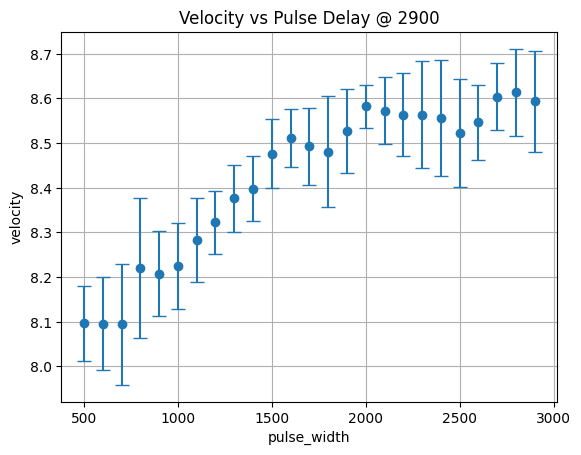

In [ ]:
# Test single stage tripple pulse delay time
# The idea is to get the projectile to move first and then time the second pulse to propel it when it is the most efficient to do so

stand.set_stage(1, [PulseTrainItem(1e-6, 1e-6)])

delay_shots = []
test_func = make_single_stage_test(stand, delay_shots, numtries=10)
for delay in range(500, 3000, 100):
  duration = 2000

  test_func([50e-6,500e-6, 2600e-6,400e-6, delay/1e6, duration/1e6])

velocity_points = []
dwell_points = []

for shot in delay_shots:
  velocity_points.append((shot.shapeA[-1].delay*1e6, shot.velocity))
  dwell_points.append((shot.shapeA[-1].delay*1e6, shot.dwellB))

plot_points_with_error(velocity_points, title=f"Velocity vs Pulse Delay @ {delay}", ylabel="velocity")
# plot_points_with_error(dwell_points, title=f"Dwell B vs Pulse Delay @ {delay}", ylabel="dwellB")

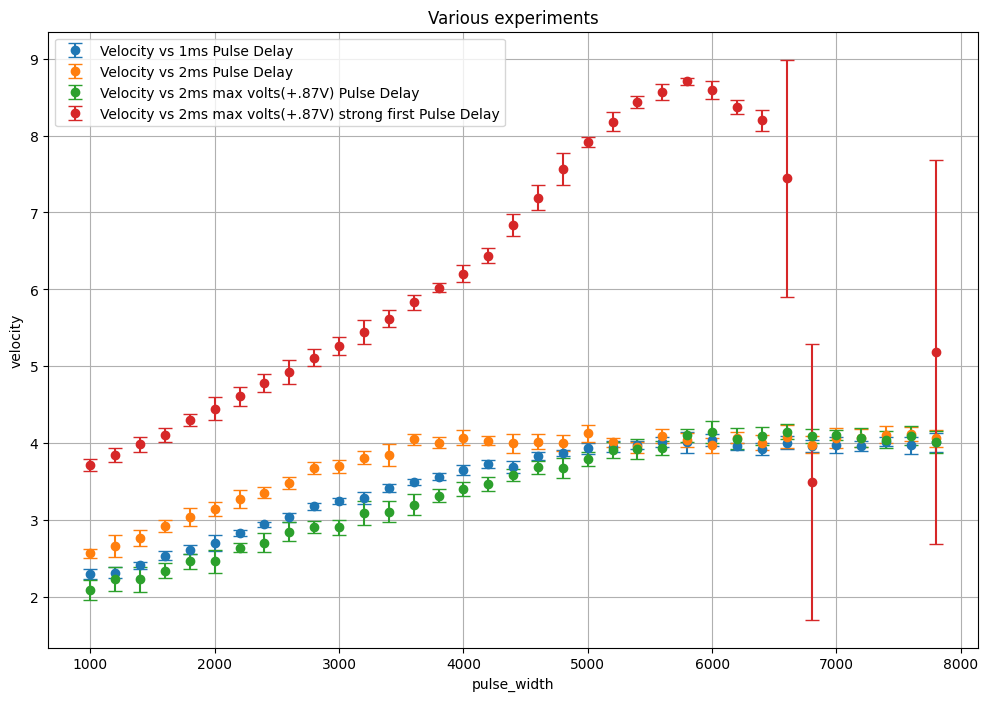

In [59]:
# velocity_points_st1 = velocity_points
# plot_points_with_error(velocity_points_1ms, title=f"Velocity vs 1ms Pulse Delay @ {delay}", ylabel="velocity")
# plot_points_with_error(velocity_points_2ms, title=f"Velocity vs 2ms Pulse Delay @ {delay}", ylabel="velocity")
# plot_points_with_error(velocity_points_maxV, title=f"Velocity vs 2ms max volts(+.87V) Pulse Delay @ {delay}", ylabel="velocity")
# plot_points_with_error(velocity_points_st1, title=f"Velocity vs 2ms max volts(+.87V) strong first Pulse Delay @ {delay}", ylabel="velocity")

plot_multiple_with_error(
  [
    ("Velocity vs 1ms Pulse Delay", velocity_points_1ms),
    ("Velocity vs 2ms Pulse Delay", velocity_points_2ms),
    ("Velocity vs 2ms max volts(+.87V) Pulse Delay", velocity_points_maxV),
    ("Velocity vs 2ms max volts(+.87V) strong first Pulse Delay", velocity_points_st1)
  ],
  title="Various experiments", ylabel="velocity"
)

In [6]:
# cap_10mf = all_shots

cap_10mf.update(all_shots)


# Gradient Ascent optimization

Iter 0: Value = 5.000000, Vars = [ 0.02 -0.04]
Iter 100: Value = 9.912060, Vars = [ 0.87003284 -1.74006567]
Iter 200: Value = 9.998453, Vars = [ 0.98276381 -1.96552762]
Iter 300: Value = 9.999973, Vars = [ 0.99771415 -1.99542829]
Iter 400: Value = 10.000000, Vars = [ 0.99969685 -1.9993937 ]
Iter 500: Value = 10.000000, Vars = [ 0.9999598  -1.99991959]
Iter 600: Value = 10.000000, Vars = [ 0.99999467 -1.99998934]
Iter 700: Value = 10.000000, Vars = [ 0.99999929 -1.99999859]
Converged at iteration 756
Opt vars: [0.9999997669929428, -1.9999995322095288]
Max value: 9.999999999999726


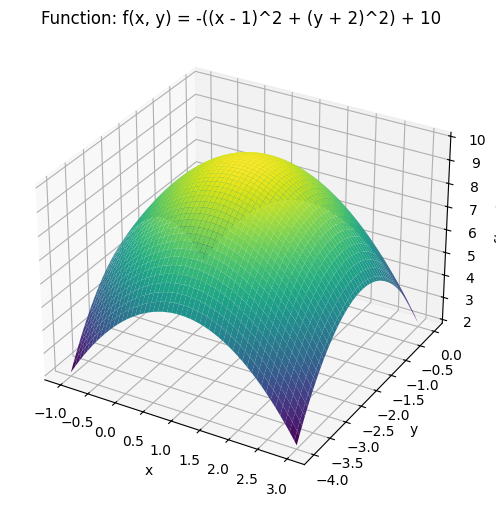

In [51]:
def gradient_ascent(
    func,
    initial_vars,
    learning_rate=0.01,
    max_iters=1000,
    tol=1e-6,
    epsilon=1e-8,
    bounds=None,   # List of (min, max) tuples for each variable
    verbose=False
):
    vars = np.array(initial_vars, dtype=float)

    for i in range(max_iters):
        current_value = func(vars)
        grad = np.zeros_like(vars)

        for j in range(len(vars)):
            vars_eps_up = vars.copy()
            vars_eps_down = vars.copy()
            vars_eps_up[j] += epsilon
            vars_eps_down[j] -= epsilon
            grad[j] = (func(vars_eps_up) - func(vars_eps_down)) / (2 * epsilon)

        if np.linalg.norm(grad) < tol:
            if verbose:
                print(f"Converged at iteration {i}")
            break

        vars += learning_rate * grad

        # Apply constraints (if any)
        if bounds is not None:
            for j in range(len(vars)):
                lower, upper = bounds[j]
                vars[j] = np.clip(vars[j], lower, upper)

        if verbose and i % 100 == 0:
            print(f"Iter {i}: Value = {current_value:.6f}, Vars = {vars}")

    return vars.tolist(), func(vars)


def test_func(v):
    x, y = v
    return -((x - 1)**2 + (y + 2)**2) + 10

# Constrain x ∈ [0, 2], y ∈ [-3, 0]
bounds = [(0, 2), (-3, 0)]

opt_vars, opt_val = gradient_ascent(test_func, initial_vars=[0, 0], bounds=bounds, verbose=True)
print("Opt vars:", opt_vars)
print("Max value:", opt_val)

# Create a meshgrid
x = np.linspace(-1, 3, 100)
y = np.linspace(-4, 0, 100)
X, Y = np.meshgrid(x, y)

# Compute function values
Z = np.array([test_func((xi, yi)) for xi, yi in zip(np.ravel(X), np.ravel(Y))])
Z = Z.reshape(X.shape)

# 3D Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
ax.set_title("Function: f(x, y) = -((x - 1)^2 + (y + 2)^2) + 10")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x, y)")
plt.show()

In [ ]:
shots = []
shape = [
  50e-6, 500e-6, 
  2600e-6, 400e-6,
  2000e-6, 2000e-6,
  ]
bounds = [
  [50e-6, 51e-6], [400e-6, 700e-6], 
  [1000e-6, 3000e-6], [50e-6, 3000e-6],
  [50e-6, 5000e-6], [3000e-6],
]
opt_vars, opt_val = gradient_ascent(make_single_stage_test(stand, shots), initial_vars=shape, bounds=bounds, verbose=True)
